# Asset-class tickers used in this notebook

**Equities (with dividend reinvestment):**
- **Sweden**: EWD — iShares Sweden MSCI ETF (Swedish equities, reinvests dividends; EXS1/OMX30 is delisted)
- **USA**: SPY — SPDR S&P 500 ETF Trust (US large-cap, S&P 500 index, reinvests dividends)
- **Emerging**: VWO — Vanguard FTSE Emerging Markets ETF (emerging markets equities, reinvests dividends)
- **Europe_Dev**: EWG — iShares Germany ETF (developed Europe equities; proxy for broader Europe exposure)

**Commodities & Alternatives:**
- **Gold**: GLD — SPDR Gold Shares (gold bullion proxy, inflation hedge)
- **Commodities**: DBC — Commodities Select Sector SPDR (diversified commodities: oil, metals, agriculture)

**REITs:**
- **REITs**: VNQ — Vanguard Real Estate ETF (US real estate investment trusts)

**Bonds (duration/maturity in name):**
- **Bonds (Short)**: SHV — iShares 1-3 Year Treasury Bond ETF (short-duration US treasuries, ~1-3 years)
- **Bonds (Long)**: TLT — iShares 20+ Year Treasury Bond ETF (long-duration US treasuries, 20+ years)
- **Bonds (TIPS)**: VTIP — Vanguard Inflation-Protected Sec. ETF (inflation-protected treasuries; inflation hedge)

- **Bonds (Corporate)**: LQD — iShares Investment Grade Corporate Bond ETF (medium-term investment grade; higher yield than treasuries)11-asset portfolio balances growth (equities), income (bonds, REITs), inflation protection (TIPS, commodities, gold), and geographic diversification.

All equity indices assume full dividend reinvestment. Bond duration/maturity range is noted in parentheses.

---------------------------------
Changes to Add:
- Cash earning normal interest
- add return expectations or risk tolerance
- get a recommended weight of portfolio returns back

In [179]:
# Notebook parameters — change these to adjust asset classes and time period
# `TICKERS` can be modified to test different asset-class mappings.
# `START_DATE` and `END_DATE` control the backtest date range.
# All equities reinvest dividends. Bonds have duration/maturity noted.
# Note: EXS1 (OMX30) was delisted; using EWD (Swedish MSCI) instead
# Example configurations:
#   - Long-term US bonds: {"Bonds_Short": "SHV", "Bonds_Long": "TLT"}
#   - European bonds: {"Bonds": "EUNL"}
#   - Long history (30+ years): Use SPY, AGG, VTI, BRK.B (since ~1990s)
#   - For optimization: Set START_DATE far in past and leave END_DATE=None for most recent data
DEFAULT_TICKERS_EXT = {
    "Sweden": "EWD", 
    "USA_SP500": "SPY", 
    "Emerging": "VWO", 
    "Europe_Dev": "EWG",
    "Gold": "GLD", 
    "Commodities": "DBC",
    "Bonds_Short_1-3Y": "SHV",
    "Bonds_Long_20Y": "TLT",
    "Bonds_TIPS": "VTIP",
    "Bonds_Corporate": "LQD",
    "REITs": "VNQ"
}
TICKERS = DEFAULT_TICKERS_EXT.copy()

# Date range examples for optimal weight discovery:
#   - "2000-01-01" to None: Full 25+ year history (includes 2000 dot-com, 2008 crisis, 2020 COVID)
#   - "2009-01-01" to None: Post-recovery bull market
#   - "1995-01-01 to "2005-01-01": Pre-crisis decade
START_DATE = "2010-01-11"  # Test period: 2023-2025. Change to "2000-01-01" for long history
END_DATE = "2025-12-31"    # Set to None to use most recent data
NUM_PORTFOLIOS = 10000
SEED = 42
SAVE_DIR = "results"
import os
os.makedirs(SAVE_DIR, exist_ok=True)
print('TICKERS:', TICKERS)

print('START_DATE:', START_DATE)

print('END_DATE:', END_DATE)
print('NUM_PORTFOLIOS:', NUM_PORTFOLIOS)

TICKERS: {'Sweden': 'EWD', 'USA_SP500': 'SPY', 'Emerging': 'VWO', 'Europe_Dev': 'EWG', 'Gold': 'GLD', 'Commodities': 'DBC', 'Bonds_Short_1-3Y': 'SHV', 'Bonds_Long_20Y': 'TLT', 'Bonds_TIPS': 'VTIP', 'Bonds_Corporate': 'LQD', 'REITs': 'VNQ'}
START_DATE: 2010-01-11
END_DATE: 2025-12-31
NUM_PORTFOLIOS: 10000


In [165]:
# Helper functions defined inline so the notebook is self-contained
from typing import Dict, Optional
import pandas as pd
import numpy as np
import yfinance as yf

TRADING_DAYS = 252

def fetch_prices(tickers: Dict[str, str], start: str, end: Optional[str] = None) -> pd.DataFrame:
    """Fetch adjusted close prices for given tickers."""
    yf_tickers = list(tickers.values())
    data = yf.download(yf_tickers, start=start, end=end, progress=False)
    
    if data.empty:
        raise RuntimeError("No data fetched. Check tickers or date range.")
    
    # yfinance returns multi-level columns: (Price Type, Ticker)
    # Extract the 'Close' or 'Adj Close' prices
    if data.columns.nlevels > 1:
        # Multi-level columns from yfinance
        level_0_values = data.columns.get_level_values(0).unique()
        
        # Try to get 'Adj Close' first, fall back to 'Close'
        if 'Adj Close' in level_0_values:
            adj = data.xs('Adj Close', level=0, axis=1)
        elif 'Close' in level_0_values:
            adj = data.xs('Close', level=0, axis=1)
        else:
            raise RuntimeError(f"Could not find 'Adj Close' or 'Close' in columns. Available: {level_0_values.tolist()}")
    elif 'Adj Close' in data.columns:
        adj = data["Adj Close"].copy()
    elif 'Close' in data.columns:
        adj = data["Close"].copy()
    else:
        raise RuntimeError("Could not find price column in downloaded data.")
    
    # Rename columns from ticker symbols to asset names
    mapping = {tickers[k]: k for k in tickers}
    try:
        adj = adj.rename(columns=mapping)
    except:
        pass
    
    adj = adj.sort_index()
    return adj

def compute_returns(prices: pd.DataFrame, method: str = "log") -> pd.DataFrame:
    if method == "log":
        return np.log(prices / prices.shift(1)).dropna()
    else:
        return prices.pct_change().dropna()

def apply_annual_fees(returns: pd.DataFrame, annual_fees: Dict[str, float]) -> pd.DataFrame:
    daily_fees = {k: (1 + v) ** (1 / TRADING_DAYS) - 1 for k, v in annual_fees.items()}
    net = returns.copy()
    for col in net.columns:
        fee = daily_fees.get(col, 0.0)
        net[col] = net[col] - fee
    return net

def apply_isk_simple_tax_on_annual(values: pd.Series, annual_tax_rate: float) -> pd.Series:
    vals = values.copy()
    yrs = vals.index.year
    year_ends = vals.groupby(yrs).apply(lambda s: s.index[-1])
    for idx in year_ends:
        tax_base = vals.loc[idx]
        vals.loc[idx:] = vals.loc[idx:] - (annual_tax_rate * tax_base)
    return vals

def portfolio_return_series(returns: pd.DataFrame, weights: Dict[str, float]) -> pd.Series:
    cols = list(weights.keys())
    w = np.array([weights[c] for c in cols])
    rets = returns[cols].dot(w)
    return rets

def cagr_from_value_series(values: pd.Series) -> float:
    days = (values.index[-1] - values.index[0]).days
    years = days / 365.25
    return (values.iloc[-1] / values.iloc[0]) ** (1 / years) - 1

def max_drawdown(values: pd.Series) -> float:
    cum = values / values.iloc[0]
    roll_max = cum.cummax()
    dd = (cum / roll_max) - 1
    return dd.min()

def annualized_vol(returns: pd.Series) -> float:
    return returns.std() * np.sqrt(TRADING_DAYS)

def sharpe_ratio(returns: pd.Series, risk_free: float = 0.0) -> float:
    ann_ret = returns.mean() * TRADING_DAYS
    ann_vol = annualized_vol(returns)
    return (ann_ret - risk_free) / ann_vol if ann_vol != 0 else np.nan

def portfolio_metrics_from_returns(portfolio_rets: pd.Series, start_value: float = 1.0, risk_free: float = 0.0) -> Dict[str, float]:
    values = (1 + portfolio_rets).cumprod() * start_value
    return {
        "CAGR": cagr_from_value_series(values),
        "AnnualVol": annualized_vol(portfolio_rets),
        "Sharpe": sharpe_ratio(portfolio_rets, risk_free),
        "MaxDrawdown": max_drawdown(values)
    }

In [166]:

# Data Validation: Check data availability for all tickers

def validate_data_coverage(tickers: Dict[str, str], start: str, end: Optional[str] = None) -> Dict:
    """
    Check data availability for all tickers. Returns coverage report.
    
    Inception dates (approximate):
    - SPY: 1993-01 | EWD: 1996-06 | TLT: 2002-07 | VNQ: 2004-09
    - GLD: 2004-11 | VWO: 2005-03 | SHV: 2007-02 | EUNL: 2007-01
    """
    print("Checking data availability for all tickers...")
    coverage = {}
    
    # Download each ticker individually to avoid timeout issues
    for asset_name, ticker in tickers.items():
        try:
            data = yf.download(ticker, start="1990-01-01", end=end, progress=False)
            
            # Handle yfinance output (may have multi-level columns)
            if isinstance(data, pd.DataFrame):
                # Try to get Adj Close; if not, try Close
                if 'Adj Close' in data.columns:
                    adj = data["Adj Close"]
                elif ('Adj Close', ticker) in data.columns:
                    adj = data[("Adj Close", ticker)]
                elif 'Close' in data.columns:
                    adj = data["Close"]
                elif ('Close', ticker) in data.columns:
                    adj = data[("Close", ticker)]
                else:
                    adj = None
            else:
                adj = data  # Already a Series
            
            if adj is not None and not adj.empty:
                first_valid = adj.first_valid_index()
                last_valid = adj.last_valid_index()
                inception_str = first_valid.strftime('%Y-%m-%d') if first_valid else 'N/A'
            else:
                first_valid = None
                last_valid = None
                inception_str = 'N/A'
            
        except Exception as e:
            first_valid = None
            last_valid = None
            inception_str = 'N/A'
            error_msg = str(e)[:40]
            print(f"  ⚠ {asset_name:20s} ({ticker}): {error_msg}")
        
        coverage[asset_name] = {
            'first_date': first_valid,
            'last_date': last_valid,
            'inception': inception_str
        }
    
    # Parse requested dates
    start_dt = pd.Timestamp(start)
    end_dt = pd.Timestamp(end) if end else pd.Timestamp.now()
    
    # Print report
    print("\n" + "=" * 80)
    print("DATA COVERAGE REPORT")
    print("=" * 80)
    print(f"Requested Period: {start} to {end if end else 'most recent'}\n")
    print(f"{'Asset':<20} {'Inception':<15} {'Latest Data':<15} {'Status'}")
    print("-" * 80)
    
    all_valid = True
    max_first_date = None
    
    for asset in sorted(coverage.keys()):
        cov = coverage[asset]
        first = cov['first_date']
        last = cov['last_date']
        
        has_start = first <= start_dt if first else False
        has_end = last >= end_dt if last else False
        status = "✓" if (has_start and has_end) else "⚠ INCOMPLETE"
        
        if not (has_start and has_end):
            all_valid = False
        
        # Track latest inception date for recommendation
        if first and (max_first_date is None or first > max_first_date):
            max_first_date = first
        
        last_str = last.strftime('%Y-%m-%d') if last else 'N/A'
        print(f"{asset:<20} {cov['inception']:<15} {last_str:<15} {status}")
    
    print("=" * 80)
    
    # Return result
    if not all_valid:
        print("\n⚠ WARNING: Not all tickers have complete data!")
        if max_first_date:
            rec_date = max_first_date.strftime('%Y-%m-%d')
            print(f"Recommendation: Use START_DATE = '{rec_date}' (latest inception date)")
            earliest = rec_date
        else:
            print("No tickers have data. Check internet connection and ticker symbols.")
            earliest = start
        return {'valid': False, 'earliest_valid_start': earliest, 'coverage': coverage}
    else:
        print("✓ All tickers have complete data for the requested period!\n")
        return {'valid': True, 'earliest_valid_start': start, 'coverage': coverage}

# Run validation
coverage_report = validate_data_coverage(TICKERS, start=START_DATE, end=END_DATE)


Checking data availability for all tickers...

DATA COVERAGE REPORT
Requested Period: 2010-01-11 to 2025-12-31

Asset                Inception       Latest Data     Status
--------------------------------------------------------------------------------
Bonds_Corporate      2002-07-30      2025-12-30      ⚠ INCOMPLETE
Bonds_Long_20Y       2002-07-30      2025-12-30      ⚠ INCOMPLETE
Bonds_Short_1-3Y     2007-01-11      2025-12-30      ⚠ INCOMPLETE
Bonds_TIPS           2012-10-16      2025-12-30      ⚠ INCOMPLETE
Commodities          2006-02-06      2025-12-30      ⚠ INCOMPLETE
Emerging             2005-03-10      2025-12-30      ⚠ INCOMPLETE
Europe_Dev           1996-03-18      2025-12-30      ⚠ INCOMPLETE
Gold                 2004-11-18      2025-12-30      ⚠ INCOMPLETE
REITs                2004-09-29      2025-12-30      ⚠ INCOMPLETE
Sweden               1996-03-18      2025-12-30      ⚠ INCOMPLETE
USA_SP500            1993-01-29      2025-12-30      ⚠ INCOMPLETE

⚠ WARNING: Not all t

In [167]:

# Auto-adjust date range for complete data coverage (optional)
# Uncomment to auto-correct START_DATE if it predates any ticker inception

AUTO_ADJUST_DATES = False  # Set to True to auto-correct START_DATE

if AUTO_ADJUST_DATES and not coverage_report['valid']:
    print("AUTO-ADJUSTING DATES FOR COMPLETE DATA COVERAGE...")
    START_DATE = coverage_report['earliest_valid_start']
    print(f"✓ START_DATE updated to: {START_DATE}")
    print("Re-run the price fetching and analysis cells with the new START_DATE.\n")
else:
    print("Date range validation complete. Proceed with analysis if all tickers show ✓ status.")
    print("(Set AUTO_ADJUST_DATES = True above to auto-correct START_DATE)\n")


Date range validation complete. Proceed with analysis if all tickers show ✓ status.
(Set AUTO_ADJUST_DATES = True above to auto-correct START_DATE)



In [168]:
# Fetch prices and show head
# Use the ticker mapping from the parameters cell
tickers = TICKERS
prices = fetch_prices(tickers, start=START_DATE, end=END_DATE)

# Forward fill NaN values from missing tickers, then drop rows with remaining NaNs
prices = prices.ffill().dropna(how='any')
print(f"Data shape after cleaning: {prices.shape}")
print(f"Missing tickers or periods that were removed.")
prices.head()

Data shape after cleaning: (3320, 11)
Missing tickers or periods that were removed.


Ticker,Commodities,Sweden,Europe_Dev,Gold,Bonds_Corporate,Bonds_Short_1-3Y,USA_SP500,Bonds_Long_20Y,REITs,Bonds_TIPS,Emerging
Date,,,,,,,,,,,
2012-10-16,24.035791,18.088516,17.379286,169.419998,77.838524,89.425880,115.375885,85.197762,38.633141,37.202938,28.639517
2012-10-17,24.044245,18.210257,17.512972,169.539993,77.686691,89.425880,115.899078,84.408470,38.527119,37.195477,28.869984
2012-10-18,24.035791,18.332003,17.490686,168.789993,77.541199,89.433983,115.597832,83.891640,38.921696,37.173115,28.788643
2012-10-19,23.672255,17.915512,17.245598,166.970001,77.680405,89.425880,113.671494,85.030136,38.597797,37.232761,28.341265
2012-10-22,23.562346,18.056477,17.305010,167.580002,77.496956,89.433983,113.687347,84.485329,38.403454,37.210388,28.632734


In [169]:
# Compute returns, apply fees and compute portfolio metrics
returns = compute_returns(prices, method="simple")
# Example annual fees (expense ratios) for the ETF proxies
fees = {
    "Sweden": 0.003, 
    "USA_SP500": 0.0009, 
    "Emerging": 0.003,
    "Europe_Dev": 0.0011,
    "Gold": 0.004, 
    "Commodities": 0.0076,
    "Bonds_Short_1-3Y": 0.0004,
    "Bonds_Long_20Y": 0.0020,
    "Bonds_TIPS": 0.0011,
    "Bonds_Corporate": 0.0013,
    "REITs": 0.0012
}
net_returns = apply_annual_fees(returns, fees)
# Example weights (must match keys in DEFAULT_TICKERS_EXT)
weights = {
    "Sweden": 0.10, 
    "USA_SP500": 0.40, 
    "Emerging": 0.10, 
    "Gold": 0.10, 
    "Bonds_Short_1-3Y": 0.10,
    "Bonds_Long_20Y": 0.05,
    "REITs": 0.15
}
metrics

port_rets = portfolio_return_series(net_returns, weights)
metrics = portfolio_metrics_from_returns(port_rets)

In [170]:
# Portfolio explorer: generate random portfolios and evaluate metrics
import numpy as np
import pandas as pd


def generate_random_portfolios(returns: pd.DataFrame, num_portfolios: int = 2000, seed: int = 42) -> pd.DataFrame:
    """Generate random weight combinations (Dirichlet), evaluate portfolio metrics over full period.
    Returns a DataFrame with one row per portfolio and columns for metrics + weights.
    """
    np.random.seed(seed)
    assets = list(returns.columns)
    n = len(assets)
    samples = np.random.dirichlet(np.ones(n), size=num_portfolios)

    rows = []
    for s in samples:
        w = {asset: float(s[i]) for i, asset in enumerate(assets)}
        port_rets = portfolio_return_series(returns, w)
        mets = portfolio_metrics_from_returns(port_rets)
        row = {"CAGR": mets["CAGR"], "AnnualVol": mets["AnnualVol"], "Sharpe": mets["Sharpe"], "MaxDrawdown": mets["MaxDrawdown"]}
        # add weights
        for i, asset in enumerate(assets):
            row[f"w_{asset}"] = s[i]
        rows.append(row)

    df = pd.DataFrame(rows)
    # optional: compute annual return for quick reference
    df["Return"] = df["CAGR"]
    return df

# Example: generate candidate portfolios using parameters
candidates = generate_random_portfolios(net_returns, num_portfolios=NUM_PORTFOLIOS, seed=SEED)
candidates.sort_values("Sharpe", ascending=False).head(10)

,CAGR,AnnualVol,Sharpe,MaxDrawdown,w_Commodities,w_Sweden,w_Europe_Dev,w_Gold,w_Bonds_Corporate,w_Bonds_Short_1-3Y,w_USA_SP500,w_Bonds_Long_20Y,w_REITs,w_Bonds_TIPS,w_Emerging,Return
5020,0.045400,0.047391,0.963548,-0.119572,0.006100,0.010662,0.026792,0.094983,0.190221,0.472679,0.126596,0.015193,0.031323,0.013629,0.011823,0.045400
4230,0.061401,0.065900,0.940249,-0.141894,0.045562,0.007248,0.006884,0.145652,0.027179,0.339081,0.243682,0.056587,0.063059,0.052281,0.012785,0.061401
3970,0.093208,0.101307,0.934031,-0.211755,0.033040,0.005495,0.011849,0.086244,0.033390,0.168180,0.535782,0.082395,0.015256,0.013425,0.014944,0.093208
6268,0.054805,0.059565,0.928194,-0.142786,0.001149,0.029987,0.001986,0.153464,0.081738,0.258821,0.165545,0.068826,0.052011,0.160104,0.026370,0.054805
8607,0.067851,0.074736,0.918775,-0.167017,0.003022,0.058916,0.001904,0.238533,0.015544,0.209976,0.242381,0.120836,0.007390,0.066116,0.035382,0.067851
399,0.065732,0.072912,0.913710,-0.151697,0.005905,0.026849,0.102112,0.135913,0.006114,0.382381,0.241912,0.046103,0.010526,0.024397,0.017788,0.065732
7826,0.043465,0.048013,0.912505,-0.116461,0.000887,0.030951,0.006653,0.078963,0.003095,0.112418,0.093387,0.054517,0.070798,0.527360,0.020971,0.043465
7843,0.051789,0.057397,0.911445,-0.142892,0.005936,0.007597,0.068148,0.043719,0.115945,0.394228,0.178950,0.053193,0.043286,0.080230,0.008767,0.051789
2057,0.058415,0.066307,0.892646,-0.149474,0.026916,0.079572,0.004276,0.132206,0.115141,0.287416,0.187168,0.029898,0.034600,0.093033,0.009774,0.058415
319,0.073836,0.084561,0.888037,-0.173315,0.005591,0.035439,0.006020,0.321310,0.147359,0.166113,0.241246,0.007718,0.042270,0.006394,0.020542,0.073836


In [171]:

# Portfolio Optimization: Markowitz mean-variance optimization
# Finds optimal weights to maximize Sharpe ratio with practical constraints
from scipy.optimize import minimize, LinearConstraint, Bounds
import warnings
warnings.filterwarnings('ignore')

def optimize_portfolio_sharpe(returns: pd.DataFrame, 
                               min_weight: float = 0.0,
                               max_weight: float = 1.0,
                               min_allocation: float = 0.05,
                               risk_free_rate: float = 0.0) -> Dict[str, float]:
    """
    Maximize Sharpe ratio using constrained optimization.
    
    Args:
        returns: DataFrame of asset returns
        min_weight: minimum weight per asset (default 0.0 = no short sales)
        max_weight: maximum weight per asset (default 1.0 = no leverage)
        min_allocation: minimum allocation for any non-zero asset (avoid tiny weights)
        risk_free_rate: risk-free rate for Sharpe calculation (default 0.0)
    
    Returns:
        Dictionary of optimal weights by asset name
    """
    assets = list(returns.columns)
    n = len(assets)
    
    # Annualized metrics
    mean_returns = returns.mean() * TRADING_DAYS
    cov_matrix = returns.cov() * TRADING_DAYS
    
    # Objective: negative Sharpe ratio (minimize to maximize Sharpe)
    def neg_sharpe(w):
        port_return = np.dot(w, mean_returns)
        port_vol = np.sqrt(np.dot(w, np.dot(cov_matrix, w)))
        if port_vol == 0:
            return 1e6
        return -(port_return - risk_free_rate) / port_vol
    
    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # weights sum to 1
    ]
    
    # Bounds: each weight between min_weight and max_weight
    bounds = tuple([(min_weight, max_weight) for _ in range(n)])
    
    # Initial guess: equal-weight
    x0 = np.array([1.0 / n for _ in range(n)])
    
    # Optimize
    result = minimize(
        neg_sharpe,
        x0,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-9, 'maxiter': 1000}
    )
    
    if not result.success:
        print(f"⚠ Optimization warning: {result.message}")
    
    # Convert to dictionary
    opt_weights = {assets[i]: float(result.x[i]) for i in range(n)}
    
    return opt_weights

# Run optimization
print("=" * 80)
print("PORTFOLIO OPTIMIZATION: Maximizing Sharpe Ratio")
print("=" * 80)

opt_weights = optimize_portfolio_sharpe(net_returns, min_weight=0.0, max_weight=1.0)

# Evaluate optimized portfolio
opt_port_rets = portfolio_return_series(net_returns, opt_weights)
opt_metrics = portfolio_metrics_from_returns(opt_port_rets)

print(f"\nOptimal Portfolio Weights (Sharpe-maximized):")
print("-" * 80)
for asset in sorted(opt_weights.keys(), key=lambda x: opt_weights[x], reverse=True):
    weight = opt_weights[asset]
    if weight > 0.001:  # Only show allocations > 0.1%
        print(f"  {asset:<25} {weight:>7.2%}")

print("\nOptimal Portfolio Metrics:")
print(f"  CAGR:       {opt_metrics['CAGR']:>7.2%}")
print(f"  Vol:        {opt_metrics['AnnualVol']:>7.2%}")
print(f"  Sharpe:     {opt_metrics['Sharpe']:>7.2f}")
print(f"  Max DD:     {opt_metrics['MaxDrawdown']:>7.2%}")
print("=" * 80)


PORTFOLIO OPTIMIZATION: Maximizing Sharpe Ratio

Optimal Portfolio Weights (Sharpe-maximized):
--------------------------------------------------------------------------------
  Bonds_Short_1-3Y           99.68%
  USA_SP500                   0.32%

Optimal Portfolio Metrics:
  CAGR:         1.59%
  Vol:          0.26%
  Sharpe:        6.12
  Max DD:      -0.48%


BENCHMARK COMPARISON: S&P 500 Only vs Optimized vs Best Random

Filtered random portfolios by CAGR >= 10.0%
Found 7 portfolios meeting target

             Strategy     CAGR  AnnualVol   Sharpe    Max DD
         S&P 500 Only 0.143283   0.168868 0.881719 -0.337228
Optimized (Markowitz) 0.015917   0.002587 6.119722 -0.004843
Best Random Portfolio 0.101781   0.124167 0.846286 -0.267000


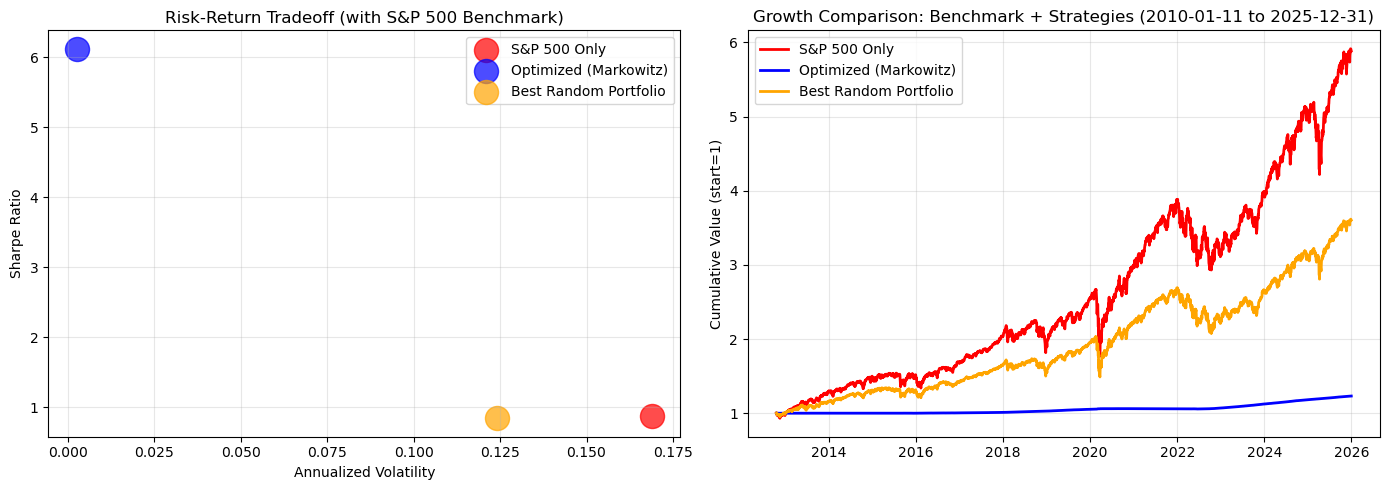

In [172]:
# Benchmark: S&P 500 only vs optimized and best random portfolios
import matplotlib.pyplot as plt

print("=" * 80)
print("BENCHMARK COMPARISON: S&P 500 Only vs Optimized vs Best Random")
print("=" * 80)

# PARAMETER: Set minimum CAGR target for best random portfolio (None = no filter)
RANDOM_CAGR_TARGET = 0.10 # Set to e.g., 0.08 for 8% CAGR minimum, or None for no filter

# Select best random portfolio based on CAGR target
if RANDOM_CAGR_TARGET is not None:
    filtered_random = candidates[candidates['CAGR'] >= RANDOM_CAGR_TARGET].copy()
    if len(filtered_random) > 0:
        best_random = filtered_random.sort_values('Sharpe', ascending=False).iloc[0]
        print(f"\nFiltered random portfolios by CAGR >= {RANDOM_CAGR_TARGET:.1%}")
        print(f"Found {len(filtered_random)} portfolios meeting target")
    else:
        print(f"\n⚠ No random portfolios found with CAGR >= {RANDOM_CAGR_TARGET:.1%}")
        print(f"Using best Sharpe regardless of CAGR")
        best_random = candidates.sort_values('Sharpe', ascending=False).iloc[0]
else:
    best_random = candidates.sort_values('Sharpe', ascending=False).iloc[0]
    print(f"\nNo CAGR filter applied - using best Sharpe overall")

best_random_weights = {asset: float(best_random[f'w_{asset}']) for asset in assets}

# S&P 500 only strategy (100% SPY)
spy_weights = {asset: 1.0 if asset == 'USA_SP500' else 0.0 for asset in assets}
spy_rets = portfolio_return_series(net_returns, spy_weights)
spy_metrics = portfolio_metrics_from_returns(spy_rets)

# All three strategies
all_strategies = {
    'S&P 500 Only': spy_weights,
    'Optimized (Markowitz)': opt_weights,
    'Best Random Portfolio': best_random_weights
}

all_rows = []
for strategy_name, weights in all_strategies.items():
    p_rets = portfolio_return_series(net_returns, weights)
    mets = portfolio_metrics_from_returns(p_rets)
    all_rows.append({
        'Strategy': strategy_name,
        'CAGR': mets['CAGR'],
        'AnnualVol': mets['AnnualVol'],
        'Sharpe': mets['Sharpe'],
        'Max DD': mets['MaxDrawdown']
    })

all_comp_df = pd.DataFrame(all_rows)
print("\n" + all_comp_df.to_string(index=False))

# Enhanced visualization with S&P 500 benchmark
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: Sharpe vs Vol
colors = {'S&P 500 Only': 'red', 'Optimized (Markowitz)': 'blue', 'Best Random Portfolio': 'orange'}
for strategy_name in all_strategies.keys():
    row = all_comp_df[all_comp_df['Strategy'] == strategy_name].iloc[0]
    ax[0].scatter(row['AnnualVol'], row['Sharpe'], s=300, alpha=0.7, label=strategy_name, color=colors.get(strategy_name, 'gray'))
ax[0].set_xlabel('Annualized Volatility')
ax[0].set_ylabel('Sharpe Ratio')
ax[0].set_title('Risk-Return Tradeoff (with S&P 500 Benchmark)')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Cumulative returns comparison (all three)
for strategy_name, weights in all_strategies.items():
    p_rets = portfolio_return_series(net_returns, weights)
    vals = (1 + p_rets).cumprod()
    ax[1].plot(vals.index, vals, label=strategy_name, linewidth=2, color=colors.get(strategy_name, 'gray'))
ax[1].set_ylabel('Cumulative Value (start=1)')
ax[1].set_title(f'Growth Comparison: Benchmark + Strategies ({START_DATE} to {END_DATE})')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 80)

Portfolios with CAGR>10%: 7


,CAGR,AnnualVol,Sharpe,MaxDrawdown,w_Commodities,w_Sweden,w_Europe_Dev,w_Gold,w_Bonds_Corporate,w_Bonds_Short_1-3Y,w_USA_SP500,w_Bonds_Long_20Y,w_REITs,w_Bonds_TIPS,w_Emerging
0,0.101781,0.124167,0.846286,-0.267000,0.004924,0.001681,0.055114,0.030714,0.006841,0.101745,0.567709,0.069369,0.101538,0.031377,0.028988
1,0.104281,0.128009,0.842758,-0.269544,0.001821,0.009312,0.062578,0.023007,0.118749,0.022814,0.600641,0.068026,0.019080,0.009116,0.064856
2,0.103214,0.127370,0.838793,-0.264711,0.000320,0.110654,0.010150,0.065870,0.085758,0.040743,0.545568,0.060355,0.022310,0.005429,0.052843


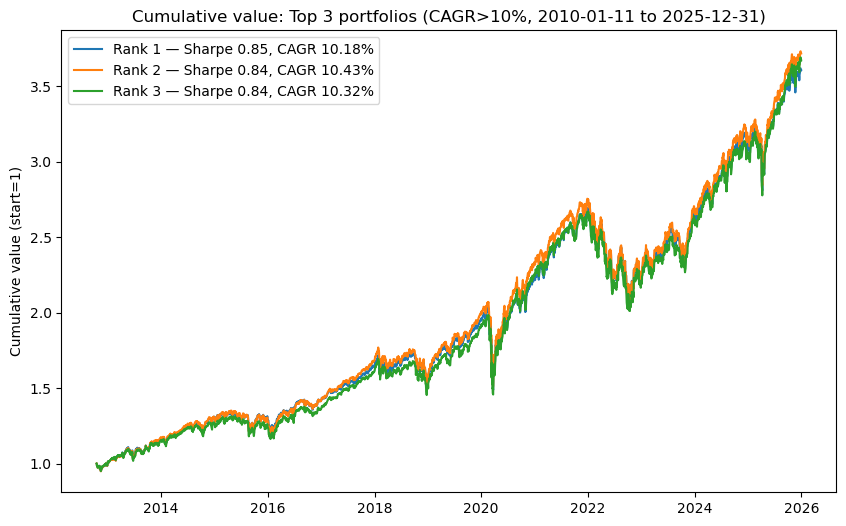

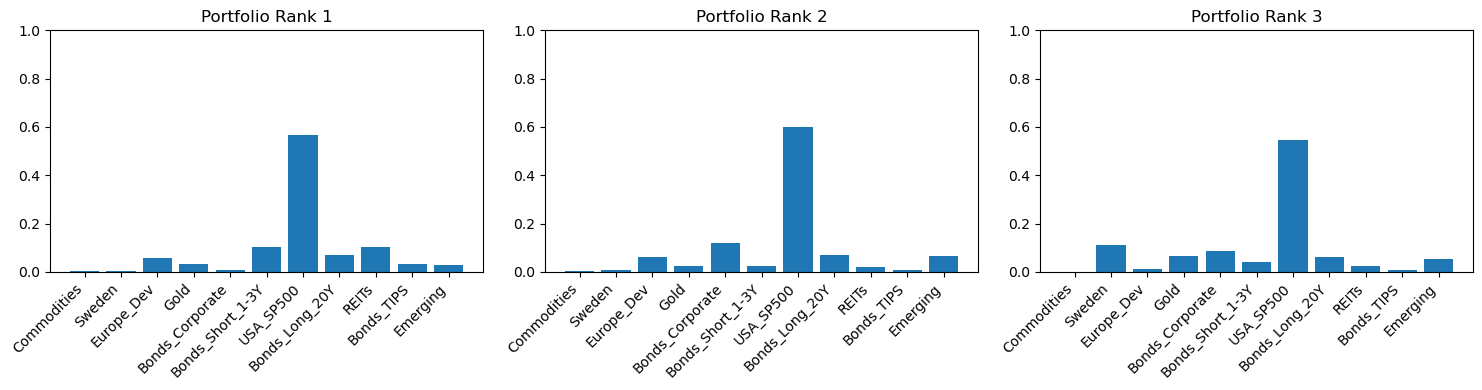

In [173]:
# Filter portfolios (CAGR > 6%) and visualize top 3 by Sharpe
import matplotlib.pyplot as plt

# Filter - adjust threshold based on period (use 8% for full period, 6% for 2007-2022)
cagr_threshold = 0.10  # Reduced threshold for 2007-2022 period which includes 2008 crisis
filtered = candidates[candidates['CAGR'] > cagr_threshold].copy()
filtered = filtered.sort_values('Sharpe', ascending=False)
print(f"Portfolios with CAGR>{cagr_threshold:.0%}: {len(filtered)}")
if len(filtered) == 0:
    print(f"No portfolios meet the CAGR>{cagr_threshold:.0%} threshold. Showing top 10 by Sharpe instead:")
    top3 = candidates.sort_values('Sharpe', ascending=False).head(3).reset_index(drop=True)
else:
    top3 = filtered.head(3).reset_index(drop=True)

display_cols = ['CAGR', 'AnnualVol', 'Sharpe', 'MaxDrawdown'] + [c for c in top3.columns if c.startswith('w_')]
display(top3[display_cols])

# Dynamic chart title based on START_DATE and END_DATE
date_range_str = f"{START_DATE} to {END_DATE}"

# cumulative returns plot for top 3
assets = list(net_returns.columns)
plt.figure(figsize=(10,6))
for i, row in top3.iterrows():
    weights = {asset: float(row[f'w_{asset}']) for asset in assets}
    p_rets = portfolio_return_series(net_returns, weights)
    vals = (1 + p_rets).cumprod()
    plt.plot(vals.index, vals, label=f"Rank {i+1} — Sharpe {row['Sharpe']:.2f}, CAGR {row['CAGR']:.2%}")
plt.legend()
plt.title(f'Cumulative value: Top 3 portfolios (CAGR>{cagr_threshold:.0%}, {date_range_str})')
plt.ylabel('Cumulative value (start=1)')
plt.show()

# weight bar charts
fig, axes = plt.subplots(1, min(3, len(top3)), figsize=(15,4))
if min(3, len(top3)) == 1:
    axes = [axes]
for i, row in top3.iterrows():
    w = [float(row[f'w_{asset}']) for asset in assets]
    ax = axes[i]
    ax.bar(assets, w)
    ax.set_title(f"Portfolio Rank {i+1}")
    ax.set_ylim(0,1)
    ax.set_xticklabels(assets, rotation=45, ha='right')
plt.tight_layout()
plt.show()

Takeaways
- V1: -> High Gold and High US and around 15-20% Bonds seems to create a good return/risk profile.
- V2 -> Still high gold, high US equities. Longer bonds. Low REIT and Emerging.
- V3 -> Test until end of 2022 to not include the gold rush. Includes 2 crisis, 2009 and 2020-2022 covid. Takeaway: lower gold but still high ~20%. Still high US equity and Long bonds.
- V4: 2010-2023. No gold! Or pretty low like 5%. Optimal mix seems to be between US eq and long bonds.
- V4 >10% CAGR. Very high US equities (65-80%), and mixing with either gold (15-20%) as a hedge, or REIT (10%), but for top 2 almost no REIT.
- V5: From 2007-2025: portfolio w 8-10% CAGR had around 1/3 S&P and 1/3 Gold 1/3 Long-term Bonds.
- V6: From 2010:2025: portfolio w 8-10% CAGR also pretty similar 1/3 S&P and 1/3 Gold 1/3 Long-term Bonds.

In [174]:
# Analyze contribution of each asset to portfolio returns for top 3 portfolios
print("=" * 80)
print("ASSET CLASS CONTRIBUTION TO TOTAL RETURN (Annualized CAGR)")
print("=" * 80)

for idx, row in top3.iterrows():
    print(f"\n{'='*80}")
    print(f"Portfolio Rank {idx + 1}")
    print(f"Overall CAGR: {row['CAGR']:.2%} | Sharpe: {row['Sharpe']:.2f} | Vol: {row['AnnualVol']:.2%}")
    print(f"{'='*80}")
    
    # Get weights for this portfolio
    weights = {asset: float(row[f'w_{asset}']) for asset in assets}
    
    # Calculate contribution of each asset
    contributions = {}
    for asset in assets:
        weight = weights[asset]
        asset_cagr = cagr_from_value_series((1 + net_returns[asset]).cumprod())
        contribution_to_return = asset_cagr * weight
        contributions[asset] = {
            'Weight': weight,
            'Asset_CAGR': asset_cagr,
            'Contribution': contribution_to_return
        }
    
    # Create DataFrame for this portfolio
    contrib_df = pd.DataFrame(contributions).T
    contrib_df = contrib_df.sort_values('Contribution', ascending=False)
    
    # Display
    print(f"{'Asset':<20} {'Weight':>10} {'Asset CAGR':>12} {'Contribution':>15}")
    print("-" * 60)
    for asset, row_data in contrib_df.iterrows():
        print(f"{asset:<20} {row_data['Weight']:>9.1%} {row_data['Asset_CAGR']:>11.2%} {row_data['Contribution']:>14.2%}")
    print("-" * 60)
    print(f"{'Total (Portfolio)':<20} {contrib_df['Weight'].sum():>9.1%} {'':>12} {contrib_df['Contribution'].sum():>14.2%}")
    print()


ASSET CLASS CONTRIBUTION TO TOTAL RETURN (Annualized CAGR)

Portfolio Rank 1
Overall CAGR: 10.18% | Sharpe: 0.85 | Vol: 12.42%
Asset                    Weight   Asset CAGR    Contribution
------------------------------------------------------------
USA_SP500                56.8%      14.33%          8.13%
REITs                    10.2%       6.44%          0.65%
Europe_Dev                5.5%       6.88%          0.38%
Gold                      3.1%       6.27%          0.19%
Bonds_Short_1-3Y         10.2%       1.55%          0.16%
Emerging                  2.9%       4.52%          0.13%
Bonds_TIPS                3.1%       2.07%          0.07%
Bonds_Corporate           0.7%       2.58%          0.02%
Sweden                    0.2%       7.56%          0.01%
Bonds_Long_20Y            6.9%       0.10%          0.01%
Commodities               0.5%      -1.20%         -0.01%
------------------------------------------------------------
Total (Portfolio)       100.0%                      

In [175]:
# Show individual asset performance for the period
print("=" * 80)
print("INDIVIDUAL ASSET PERFORMANCE (2023-2025)")
print("=" * 80)
print(f"\nPeriod: {START_DATE} to {END_DATE}\n")

asset_perf = []
for asset in assets:
    asset_cagr = cagr_from_value_series((1 + net_returns[asset]).cumprod())
    asset_vol = annualized_vol(net_returns[asset])
    asset_sharpe = sharpe_ratio(net_returns[asset])
    
    # Calculate start and end prices
    start_price = prices[asset].iloc[0]
    end_price = prices[asset].iloc[-1]
    total_return = (end_price / start_price - 1)
    
    asset_perf.append({
        'Asset': asset,
        'CAGR': asset_cagr,
        'AnnualVol': asset_vol,
        'Sharpe': asset_sharpe,
        'Total_Return': total_return,
        'Start_Price': start_price,
        'End_Price': end_price
    })

perf_df = pd.DataFrame(asset_perf).sort_values('CAGR', ascending=False)

print(f"{'Asset':<20} {'CAGR':>10} {'Total Ret':>10} {'Vol':>10} {'Sharpe':>10}")
print("-" * 65)
for _, row in perf_df.iterrows():
    print(f"{row['Asset']:<20} {row['CAGR']:>9.2%} {row['Total_Return']:>9.2%} {row['AnnualVol']:>9.2%} {row['Sharpe']:>9.2f}")
print("=" * 80)


INDIVIDUAL ASSET PERFORMANCE (2023-2025)

Period: 2010-01-11 to 2025-12-31

Asset                      CAGR  Total Ret        Vol     Sharpe
-----------------------------------------------------------------
USA_SP500               14.33%   495.45%    16.89%      0.88
Sweden                   7.56%   173.93%    22.26%      0.44
Europe_Dev               6.88%   145.98%    20.29%      0.43
REITs                    6.44%   130.94%    19.48%      0.42
Gold                     6.27%   135.44%    15.35%      0.47
Emerging                 4.52%    87.89%    19.18%      0.33
Bonds_Corporate          2.58%    42.17%     7.99%      0.36
Bonds_TIPS               2.07%    32.97%     2.56%      0.82
Bonds_Short_1-3Y         1.55%    23.14%     0.26%      5.99
Bonds_Long_20Y           0.10%     3.12%    14.58%      0.08
Commodities             -1.20%    -5.81%    16.72%      0.01


In [176]:
# ISK tax example (simple annual tax at year-end)
start_value = 1.0
values = (1 + port_rets).cumprod() * start_value
tax_rate = 0.003  # example 0.3% annual schablon
values_after_tax = apply_isk_simple_tax_on_annual(values, tax_rate)
print('CAGR before tax:', cagr_from_value_series(values))
print('CAGR after tax:', cagr_from_value_series(values_after_tax))

CAGR before tax: 0.09309390430191389
CAGR after tax: 0.09117118181161232


In [177]:
# Save filtered/top3 if available
if 'top3' in globals():
    top3.to_csv(os.path.join(SAVE_DIR, 'top3_portfolios_v3.csv'), index=False)
    print(f"Saved top3 to {os.path.join(SAVE_DIR, 'top3_portfolios.csv')}")
else:
    print('`top3` not found in notebook globals — run the filter cell first.')

Saved top3 to results\top3_portfolios.csv


In [178]:
# Save candidate portfolios and top performers to disk
import os
candidates.to_csv(os.path.join(SAVE_DIR, 'candidates.csv'), index=False)
print(f"Saved candidates to {os.path.join(SAVE_DIR, 'candidates.csv')}")

# Save filtered/top3 if available
if 'top3' in globals():
    top3.to_csv(os.path.join(SAVE_DIR, 'top3_portfolios.csv'), index=False)
    print(f"Saved top3 to {os.path.join(SAVE_DIR, 'top3_portfolios.csv')}")
else:
    print('`top3` not found in notebook globals — run the filter cell first.')

# Save the price series used
prices.to_csv(os.path.join(SAVE_DIR, 'prices.csv'))
print(f"Saved prices to {os.path.join(SAVE_DIR, 'prices.csv')}")

# Optionally save the net_returns (returns after fees)
net_returns.to_csv(os.path.join(SAVE_DIR, 'net_returns.csv'))
print(f"Saved net_returns to {os.path.join(SAVE_DIR, 'net_returns.csv')}")

Saved candidates to results\candidates.csv
Saved top3 to results\top3_portfolios.csv
Saved prices to results\prices.csv
Saved net_returns to results\net_returns.csv


**Next steps**: add plotting, implement a proper ISK schablon calculation using the official formula (government rate + 1%), and add an optimizer to maximize Sharpe under constraints.